C:\Users\ramav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5330 - loss: 1.5043 - val_accuracy: 0.7880 - val_loss: 0.5874
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7751 - loss: 0.6459 - val_accuracy: 0.7980 - val_loss: 0.6118
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8098 - loss: 0.5221 - val_accuracy: 0.8550 - val_loss: 0.3964
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8448 - loss: 0.4481 - val_accuracy: 0.8510 - val_loss: 0.3938
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8649 - loss: 0.3922 - val_accuracy: 0.8400 - val_loss: 0.3869
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8674 - loss: 0.3600 - val_accuracy: 0.8280 - val_loss: 0.4918
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8582 - loss: 0.3922 - val_accuracy: 0.8470 - val_loss: 0.3934
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8890 - loss: 0.3333 - val_accu

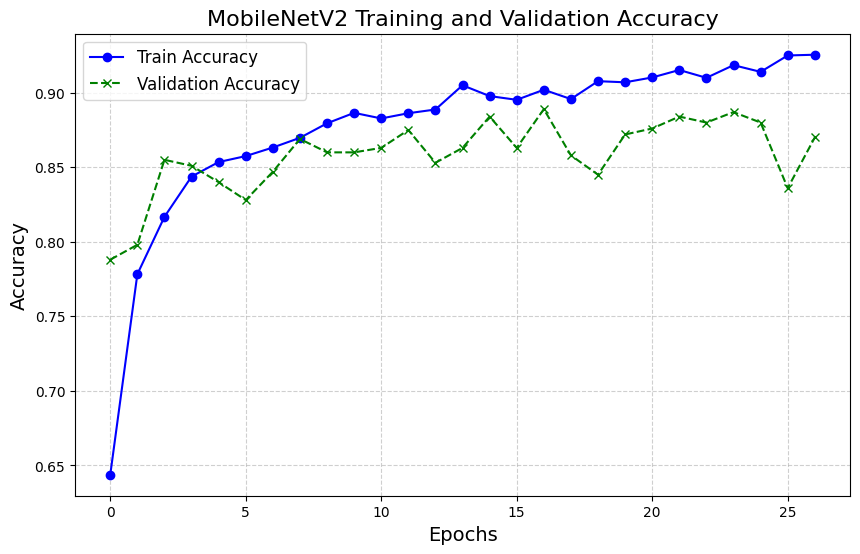

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MobileNetV2 Classification Report:
              precision    recall  f1-score   support

      Broken       0.90      0.83      0.87       201
    Immature       0.97      0.85      0.91       225
      Intact       0.84      0.97      0.90       241
Skin-Damaged       0.87      0.91      0.89       226
     Spotted       0.87      0.84      0.86       107

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.89      0.89      1000



In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load extracted DenseNet features
densenet_train_features, train_labels, densenet_test_features, test_labels = joblib.load('densenet_features.joblib')

# MobileNetV2-inspired Model Architecture
mobilenetv2_classifier = Sequential([
    Dense(1024, activation='relu', input_shape=(1024,)),  # Input shape matches DenseNet feature size
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Number of output classes
])

mobilenetv2_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model saving
mobilenetv2_checkpoint = ModelCheckpoint('mobilenetv2.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

# Train the MobileNetV2 model using DenseNet features
mobilenetv2_history = mobilenetv2_classifier.fit(
    densenet_train_features, train_labels,
    epochs=50,
    validation_data=(densenet_test_features, test_labels),
    callbacks=[mobilenetv2_checkpoint, early_stop]
)

# Plot MobileNetV2 accuracy graphs
plt.figure(figsize=(10, 6))  # Larger figure size for better readability
plt.plot(mobilenetv2_history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(mobilenetv2_history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='--', marker='x')
plt.title('MobileNetV2 Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Classification Report for MobileNetV2
mobilenetv2_predictions = mobilenetv2_classifier.predict(densenet_test_features)
mobilenetv2_pred_labels = mobilenetv2_predictions.argmax(axis=1)
print("MobileNetV2 Classification Report:")
print(classification_report(test_labels.argmax(axis=1), mobilenetv2_pred_labels, target_names=['Broken', 'Immature', 'Intact', 'Skin-Damaged', 'Spotted']))


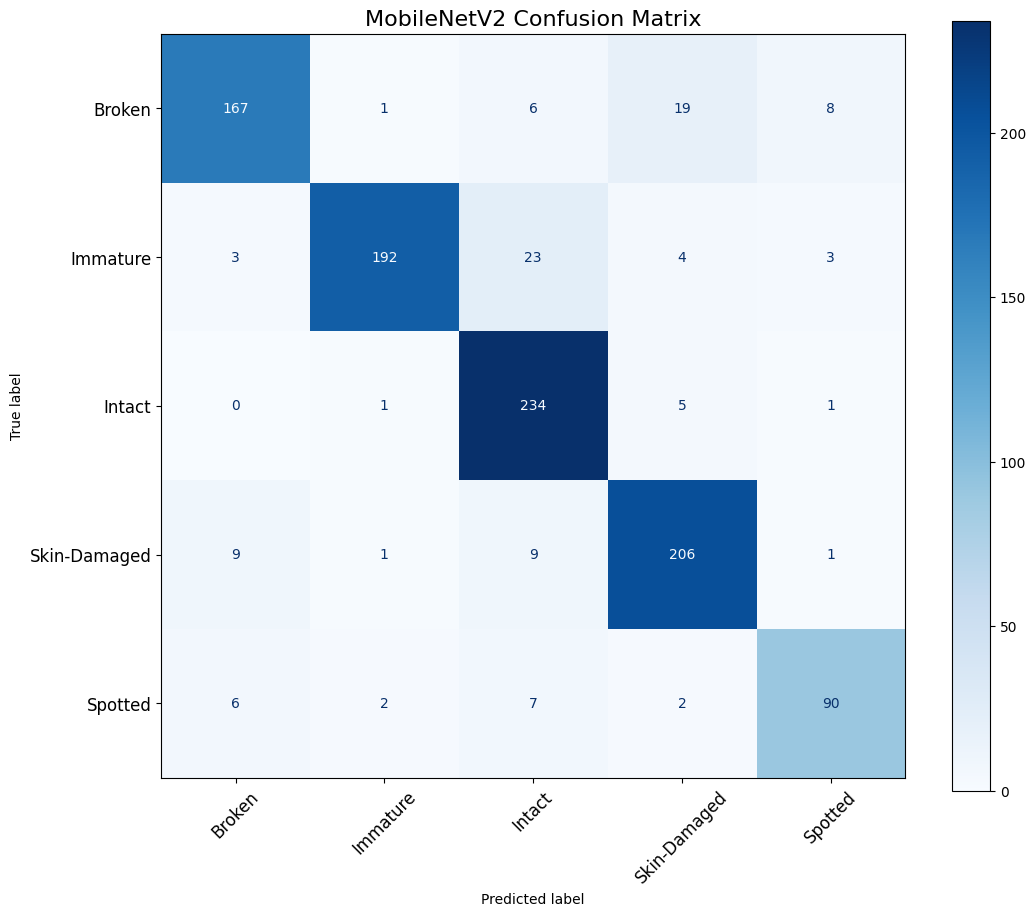

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
mobilenetv2_confusion_matrix = confusion_matrix(test_labels.argmax(axis=1), mobilenetv2_pred_labels)

# Plot the confusion matrix with adjusted labels
plt.figure(figsize=(12, 10))  # Increased figure size for better spacing
disp = ConfusionMatrixDisplay(confusion_matrix=mobilenetv2_confusion_matrix, 
                              display_labels=['Broken', 'Immature', 'Intact', 'Skin-Damaged', 'Spotted'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)               # Adjust y-axis label font size
plt.title('MobileNetV2 Confusion Matrix', fontsize=16)
plt.show()

